# Benchmarking

> Comparing the DRSA model to some other baseline models.

* *Note*: with the drsa, we can use embeddings. With the other models we cannot.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from drsa.model import DRSA

from pull_the_pitcher.data import processing, pipeline
from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics
from pull_the_pitcher.utils import get_starts, front_pad, PTPDataset, save_model, load_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train = pd.read_csv("../data/processed/train_2017_2018_2016.csv")
val = pd.read_csv("../data/processed/val_2017_2018_2016.csv")
test = pd.read_csv("../data/processed/test_2019.csv")
data = {"train": train,
        "val": val,
        "test": test}

with open("../data/processed/mappers_2017_2018_2016_2019.pkl", "rb") as f:
    mappers = pickle.load(f)
    
with open("../data/processed/scaler_2017_2018_2016_2019.pkl", "rb") as f:
    scaler = pickle.load(f)
    
# scaling test data (as tuned on training data)
data["test"][pipeline.feature_cols] = scaler.transform(data["test"][pipeline.feature_cols])

# replacing pitcher id with index of associated embedding
data["test"]["pitcher"] = [mappers["pitcher"].get(pitcher, 0) for pitcher in data["test"]["pitcher"]]

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
X_train, X_test, y_train, y_test = train[pipeline.feature_cols], test[pipeline.feature_cols], train["pulled"], test["pulled"] 

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     45155
         1.0       0.67      0.21      0.32      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.60      0.65     47189
weighted avg       0.95      0.96      0.95     47189

mean plate appearance diff: 0.22026
mean target diff: 0.02861


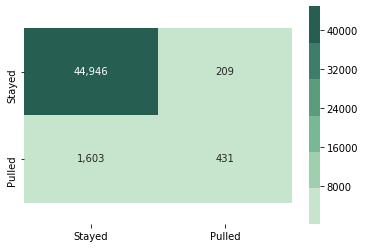

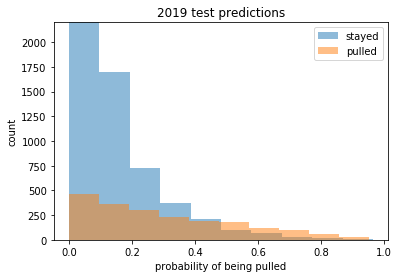

In [7]:
print_all_metrics(y_test, log_reg.predict_proba(X_test)[:, 1], thresh=0.5)

## Gradient-Boosted Tree

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

In [9]:
gbt = GradientBoostingClassifier(subsample=0.5)
gbt.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     45155
         1.0       0.68      0.27      0.39      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.63      0.69     47189
weighted avg       0.96      0.96      0.96     47189

mean plate appearance diff: 0.18437
mean target diff: 0.0288


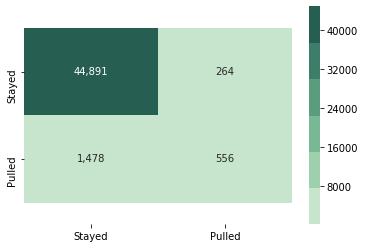

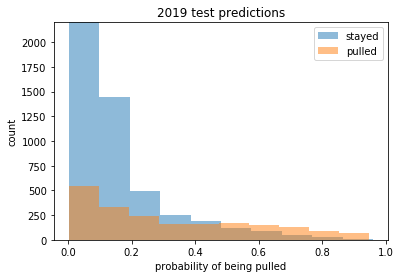

In [10]:
print_all_metrics(y_test, gbt.predict_proba(X_test)[:, 1], thresh=0.5)

## DRSA

In [11]:
# quick dropping of a few unneeded columns
cols_to_drop = ['game_pk', 'game_type', 'pitcher_team_year']
for dataset in data.values():
    dataset = dataset.drop(columns=cols_to_drop)

cols = pipeline.cols
for c in cols_to_drop:
    cols.remove(c)

In [12]:

padded_starts = {}
for set_, dataset in data.items():
    starts = get_starts(dataset, cols=cols, y_col="pulled")
    starts = add_targets(starts)
    padded_starts[set_] = front_pad(starts)

In [14]:

# instantiating datasets
datasets = {}
for set_, starts in padded_starts.items():
    datasets[set_] = PTPDataset(starts)

# instantiating data loaders
dataloaders = {}
for set_, dataset in datasets.items():
    dataloaders[set_] = DataLoader(dataset, batch_size=256)

In [15]:
# getting embeddings ready
n_pitchers = 270
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=17,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.05,
            Linear_dropout=0.1)

In [16]:
! ls ../models/

06-17-20_DRSA_2017_2018_2019_loss_0.084.pth
06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth
07-07-20_DRSA_2017_2018_2019_loss_0.3017.pth
07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth
07-15-20_DRSA_2016_2017_2018_2019_loss_2.9833.pth
07-15-20_LSTM_2016_2017_2018_2019_loss_0.3965.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_2.6064.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_2.6398.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_3.749.pth
07-22-20_DRSA_2016_2017_2018_2019_loss_4.0985.pth
07-22-20_embeddings_2016_2017_2018_2019_loss_2.6064.pth


In [17]:
# loading up saved model
load_model(drsa, f"../models/07-22-20_DRSA_2016_2017_2018_2019_loss_4.0985.pth")
drsa.eval()

# organizing preds in df
dfs = {}
for set_, starts in padded_starts.items():
    features = np.concatenate(starts, axis=0)
    preds = []
    for X, y in dataloaders[set_]:
        pred = drsa(X).squeeze(0).detach().numpy().reshape(-1, 1)
        preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    dfs[set_] = pd.DataFrame(np.hstack([features, preds]), columns=cols+["last_batter", "pred"])

# getting rid of predictions for embeddings which do not occur in training set
dfs["test"] = dfs["test"].loc[(dfs["test"]["pitcher"]!=0)]

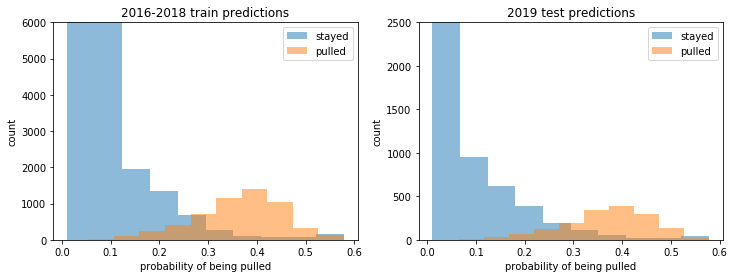

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(dfs["train"]["last_batter"], dfs["train"]["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(dfs["test"]["last_batter"], dfs["test"]["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     36447
         1.0       0.89      0.41      0.56      1616

    accuracy                           0.97     38063
   macro avg       0.93      0.70      0.77     38063
weighted avg       0.97      0.97      0.97     38063

mean plate appearance diff: 0.0
mean target diff: 0.00955


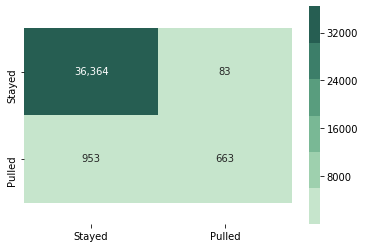

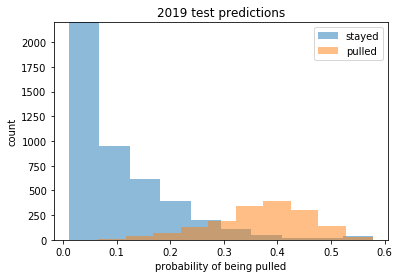

In [19]:
print_all_metrics(dfs["test"]["last_batter"], dfs["test"]["pred"], thresh=0.4)

## Log loss LSTM

In [24]:
# loading up saved model
load_model(drsa, f"../models/07-15-20_LSTM_2016_2017_2018_2019_loss_0.3965.pth")
drsa.eval()

# organizing test preds in df
test_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_test, y_test in test_dl:
    pred = drsa(X_test).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
test_df = pd.DataFrame(np.hstack([test_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

(array([3.397e+03, 2.980e+02, 2.170e+02, 3.480e+02, 8.280e+02, 3.600e+02,
        4.400e+01, 4.200e+01, 4.000e+00, 1.000e+00]),
 array([0.00038858, 0.00038887, 0.00038916, 0.00038944, 0.00038973,
        0.00039002, 0.00039031, 0.00039059, 0.00039088, 0.00039117,
        0.00039146]),
 <a list of 10 Patch objects>)

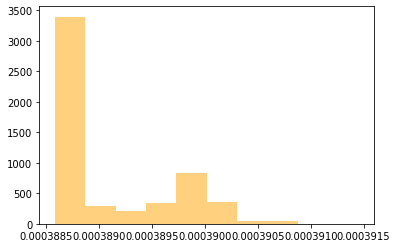

In [25]:
stayed_preds = train_df.loc[(train_df["last_batter"]==0), "pred"]
pulled_preds = train_df.loc[(train_df["last_batter"]==1), "pred"]

# plt.hist(stayed_preds, alpha=0.5, label="stayed")
plt.hist(pulled_preds, alpha=0.5, label="pulled", color="orange")
# plt.ylim(0, 300)

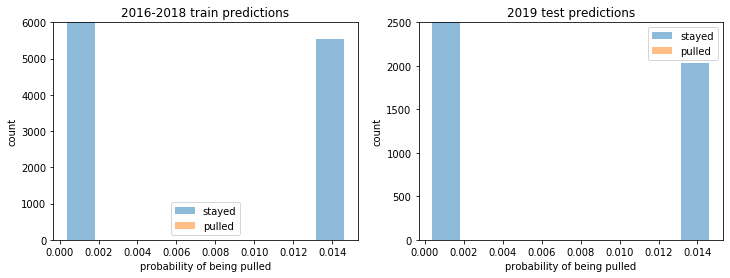

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(test_df["last_batter"], test_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     71190
         1.0       0.00      0.00      0.00      2034

    accuracy                           0.97     73224
   macro avg       0.49      0.50      0.49     73224
weighted avg       0.95      0.97      0.96     73224

mean plate appearance diff: 35.0
mean target diff: 0.02698


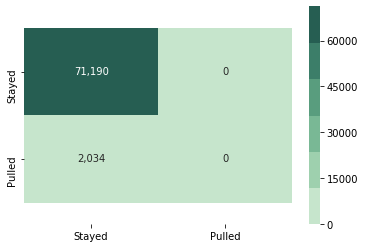

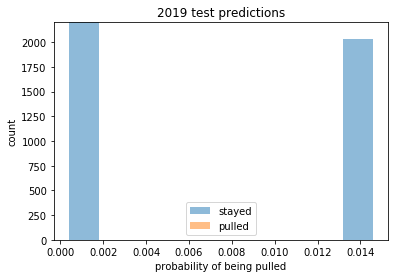

In [27]:
print_all_metrics(test_df["last_batter"], test_df["pred"], thresh=0.5)